This notebook illustrates how we:

- Measure model's consistency on full-ET-dataset
- Measure model's accuracy on full-ET-dataset
- Measure model's after constraint reasoning consistency on full-ET-dataset
- Measure model's after constraint reasoning accuracy on full-ET-dataset
- Construct the plots presented in our paper

In [1]:
from check_constraints import * 
from relations import *
import csv
import pickle
import os
import ast

In [3]:
# model_name = "Macaw-11B"
# model_name = "Macaw-3B"
# model_name = "Macaw-large"
# model_name = "UnifiedQA"
model_name = "gpt3-text-davinci-003"

# Consistency

In [2]:
def convert_to_all_triplets_TF_dict(all_triplets, chosen_triplets):
    chosen_triplets_TF_dict = {}
    for triplet_TF_conf in all_triplets:
        triplet = triplet_TF_conf[0]
        if triplet in chosen_triplets:
            chosen_triplets_TF_dict[triplet] = True
        else:
            chosen_triplets_TF_dict[triplet] = False

    assert len(all_triplets) == len(chosen_triplets_TF_dict)
    return chosen_triplets_TF_dict

In [3]:
def compare_constraint_violations_before_after(statements_dir, all_results_filename):
    #read
    with open(statements_dir + all_results_filename, 'rb') as f:
        all_result_dict = pickle.load(f) 
    
    #model_believes_dict = convert_to_all_triplets_TF_dict(all_result_dict["macaw_predictions"], all_result_dict["model_believe_true_props"])
    model_believes_dict = all_result_dict["model_believe_true_props"]
    print("="*10, "Model's beliefs", "="*10)
    before_violate, before_total, before_tuple_n_d = get_all_constraint_violations(model_believes_dict, verbose=True, max_sat_applied=False)
    
    # maxsat_selected_dict = convert_to_all_triplets_TF_dict(all_result_dict["macaw_predictions"], all_result_dict["maxsat_selected_props"])
    maxsat_selected_dict = all_result_dict["maxsat_selected_props"]
    print("="*10, "Maxsat selected", "="*10)
    after_violate, after_total, after_tuple_n_d = get_all_constraint_violations(maxsat_selected_dict, verbose=True, max_sat_applied=True)
    print()
    
    return before_violate, before_total, before_tuple_n_d, after_violate, after_total, after_tuple_n_d

In [4]:
%%capture cap --no-stderr

# statements_dir = "0_" + model_name + "-ImagineADevice-CSP-Viz-full-ET-dataset/Props/"
statements_dir = "outputs/Props/"
before_violate_cnt =0
before_total_cnt = 0

after_violate_cnt = 0
after_total_cnt = 0

n_d_by_type = {"before": {"type1": [0,0], "type2": [0,0], "type3": [0,0], "type4": [0,0]},\
               "after": {"type1": [0,0], "type2": [0,0], "type3": [0,0], "type4": [0,0]}}

before_mm_w_violate_cnt = 0
after_mm_w_violate_cnt = 0

for all_results_filename in os.listdir(statements_dir):
    if all_results_filename.startswith("."):
        continue
        
    print(all_results_filename)
    print("*" * 15, all_results_filename.rsplit("_threshold",1)[0], "*" * 15)
    before_violate, before_total, before_tuple_n_d, after_violate, after_total, after_tuple_n_d = compare_constraint_violations_before_after(statements_dir, all_results_filename)
    
    before_violate_cnt += before_violate
    before_total_cnt += before_total
    if before_violate > 0:
        before_mm_w_violate_cnt += 1
    for type_idx, (n, d) in enumerate(before_tuple_n_d):
        n_d_by_type["before"]["type" + str(type_idx + 1)][0] += n 
        n_d_by_type["before"]["type" + str(type_idx + 1)][1] += d 
        
    after_violate_cnt += after_violate
    after_total_cnt += after_total
    if after_violate > 0:
        after_mm_w_violate_cnt += 1
    for type_idx, (n, d) in enumerate(after_tuple_n_d):
        n_d_by_type["after"]["type" + str(type_idx + 1)][0] += n 
        n_d_by_type["after"]["type" + str(type_idx + 1)][1] += d 
    
    

In [6]:
# with open('full-ET-dataset-' + model_name + '-consistency-dump.txt', 'w') as f:
#     f.write(cap.stdout)

In [5]:
print("*" * 10,"Macaw-11B", "*" * 10)
print("Number of MMs", len(os.listdir(statements_dir)))
print("TOTAL VIOLATE COUNT before maxsat {}/{} ({})".format(before_violate_cnt, before_total_cnt, round(before_violate_cnt/before_total_cnt * 100, 2)))

print("TOTAL VIOLATE COUNT after maxsat {}/{} ({})".format(after_violate_cnt, after_total_cnt, round(after_violate_cnt/after_total_cnt * 100, 2)))

# by constraint type
for before_after in n_d_by_type:
    print(before_after, "maxsat:")
    per_type_avg_n = 0
    per_type_avg_d = 0
    for contraint_type in n_d_by_type[before_after]:
        cur_n, cur_d = n_d_by_type[before_after][contraint_type]
        if cur_d == 0:
            print(contraint_type, "violate count : {}/{}".format(cur_n, cur_d))
            print("Not applicable for given mental model!")
        else:
            print(contraint_type, "violate count : {} ({}/{})".format(round(cur_n/cur_d * 100, 2), cur_n, cur_d))
            per_type_avg_n += cur_n/cur_d * 100
            per_type_avg_d += 1
    print("macro avg (equal weight to each category):", round(per_type_avg_n/per_type_avg_d, 2))


print("MMs with VIOLATE before maxsat {}/{} ({})".format(before_mm_w_violate_cnt, len(os.listdir(statements_dir)), round(before_mm_w_violate_cnt/len(os.listdir(statements_dir)) * 100, 2)))

print("MMs with VIOLATE after maxsat {}/{} ({})".format(after_mm_w_violate_cnt, len(os.listdir(statements_dir)), round(after_mm_w_violate_cnt/len(os.listdir(statements_dir)) * 100, 2)))


********** Macaw-11B **********
Number of MMs 80
TOTAL VIOLATE COUNT before maxsat 4893/12391 (39.49)
TOTAL VIOLATE COUNT after maxsat 0/16948 (0.0)
before maxsat:
type1 violate count : 25.06 (205/818)
type2 violate count : 68.63 (2428/3538)
type3 violate count : 42.38 (1604/3785)
type4 violate count : 15.44 (656/4250)
macro avg (equal weight to each category): 37.88
after maxsat:
type1 violate count : 0.0 (0/1254)
type2 violate count : 0.0 (0/7524)
type3 violate count : 0.0 (0/3762)
type4 violate count : 0.0 (0/4408)
macro avg (equal weight to each category): 0.0
MMs with VIOLATE before maxsat 80/80 (100.0)
MMs with VIOLATE after maxsat 0/80 (0.0)


# Accuracy

Use annotated gold answers

In [6]:
et2triplets_ann = {}
with open("enriched_mms/full-ET-dataset.tsv", "r") as dataset:
    lines = csv.reader(dataset, delimiter = "\t")
    for line_idx, line in enumerate(lines):
        # skip header
        if line_idx == 0:
            continue
            
        # per MM as in an everyday thing sketched by a turker
        et_turker = (line[0], line[1])
        if et_turker not in et2triplets_ann:
            et2triplets_ann[et_turker] = {"triplets": [], "parts-list": []}
           
        # collect list of (triplet_tuple, True_False_label)
        triplet = ast.literal_eval(line[2])
        annotated_relation = (triplet, line[3])
        assert annotated_relation not in et2triplets_ann[et_turker]["triplets"]
        et2triplets_ann[et_turker]["triplets"].append(annotated_relation)
        
        # also collect a list of unique parts
        for part in (triplet[0], triplet[2]):
            if part not in et2triplets_ann[et_turker]["parts-list"]:
                et2triplets_ann[et_turker]["parts-list"].append(part)

In [7]:
def evaluate_accuracy_for_given_belief_dict(to_evaluate, annotated_answers, verbose=False, relation_analysis=False):
    correct = 0
    total = 0 
    rln2_correct_total = {}
    for triplet, gold_answer in annotated_answers:
        
        rln = triplet[1]
        if rln not in rln2_correct_total:
            rln2_correct_total[rln] = {"correct": 0, "total": 0}
            
        if (gold_answer == "True" and triplet in to_evaluate) or (gold_answer == "False" and triplet not in to_evaluate):
            correct += 1
            print("MODEL CORRECT: relation", triplet, " gold answer:", gold_answer)
            rln2_correct_total[rln]["correct"] += 1
        else:
            if verbose:
                print("MODEL INCORRECT: relation", triplet, " gold answer:", gold_answer)

        total += 1
        rln2_correct_total[rln]["total"] += 1
        
    if relation_analysis:
        return correct, total, rln2_correct_total
    else:
        return correct, total

In [8]:
et2triplets_ann

{('air conditioner',
  'worker_100'): {'triplets': [(('hot coils', 'connects', 'expansion valve'),
    'True'),
   (('hot coils', 'connects', 'compressor'), 'True'),
   (('expansion valve', 'connects', 'cold coils'), 'True'),
   (('compressor', 'connects', 'cold coils'), 'True'),
   (('expansion valve', 'connects', 'hot coils'), 'True'),
   (('compressor', 'connects', 'hot coils'), 'True'),
   (('cold coils', 'connects', 'expansion valve'), 'True'),
   (('cold coils', 'connects', 'compressor'),
    'True')], 'parts-list': ['hot coils',
   'expansion valve',
   'compressor',
   'cold coils']},
 ('air conditioner',
  'worker_101'): {'triplets': [(('hot coils', 'connects', 'compressor'),
    'True'),
   (('hot coils', 'requires', 'compressor'), 'True'),
   (('hot coils', 'connects', 'expansion valve'), 'True'),
   (('compressor', 'connects', 'cold coils'), 'True'),
   (('cold coils', 'requires', 'compressor'), 'True'),
   (('cold coils', 'connects', 'expansion valve'), 'True'),
   (('comp

In [9]:
all_results_filename

'earphone_worker_101_threshold50.pkl'

In [10]:
%%capture cap --no-stderr
before_name = "model_believe_true_props"
after_name = "maxsat_selected_props"
# before_name = "model_believe_true_props_filtered"
# after_name = "maxsat_selected_props_filtered"
improve_cnt = 0
worsen_cnt = 0
same_cnt = 0
mm_total = 0
overall_correct_cnt = {before_name:0, after_name: 0}
overall_total_cnt = {before_name:0, after_name: 0}
overall_improvement = 0

acc_at_s = {before_name: {50: 0, 60: 0, 70: 0, 80: 0, 90: 0, 100: 0}, after_name: {50: 0, 60: 0, 70: 0, 80: 0, 90: 0, 100: 0}}
et2_correct_total_overall = {before_name: {}, after_name: {}}
rln2_correct_total_overall = {before_name: {}, after_name: {}}

# analysis
size_of_mm_and_improvement = []

for all_results_filename in os.listdir(statements_dir):
    if all_results_filename.startswith("."):
        continue
        
    # Annotated answers
    et, turker = all_results_filename.replace("_threshold50.pkl", "").split('_',1)
    print(et, turker)
    annotated_answers = et2triplets_ann[(et.replace("-"," "), turker)]['triplets']
    print(et, turker)
    
    # Model's MM
    with open(statements_dir + all_results_filename, 'rb') as f:
            all_result_dict = pickle.load(f) 
    
    # Evaluate
    correct_cnt = {before_name:0, after_name: 0}
    total_cnt = {before_name:0, after_name: 0}
    
    for prop_type in [before_name, after_name]:
        to_evaluate = all_result_dict[prop_type]
        print(prop_type)
        correct, total, rln2_correct_total = evaluate_accuracy_for_given_belief_dict(to_evaluate, annotated_answers, verbose=True, relation_analysis=True)
        correct_cnt[prop_type] = correct
        overall_correct_cnt[prop_type] += correct
        total_cnt[prop_type] = total
        overall_total_cnt[prop_type] += total
        
        # Calculate accuracy at s
        cur_acc = correct/total * 100
        for s in acc_at_s[before_name]:
            if cur_acc >= s:
                acc_at_s[prop_type][s] += 1
#         if prop_type == before_name and cur_acc < 20:
#             print(all_results_filename)

        # Analyze by relationship
        for rln in rln2_correct_total:
            if rln not in rln2_correct_total_overall[prop_type]:
                rln2_correct_total_overall[prop_type][rln] = rln2_correct_total[rln]
            else:
                rln2_correct_total_overall[prop_type][rln]["correct"] += rln2_correct_total[rln]["correct"]
                rln2_correct_total_overall[prop_type][rln]["total"] += rln2_correct_total[rln]["total"]
        
        #  Analyze by ET
        if et not in et2_correct_total_overall[prop_type]:
            et2_correct_total_overall[prop_type][et] = {"correct": 0, "total": 0}
        et2_correct_total_overall[prop_type][et]["correct"] += correct
        et2_correct_total_overall[prop_type][et]["total"] += total
                
        
    assert total_cnt[before_name] == total_cnt[after_name]
    print("model_believe", "accuracy: {}/{} ({})".format(correct_cnt[before_name],\
            total_cnt[before_name],\
            round(correct_cnt[before_name]/total_cnt[before_name],2)))

    print("maxsat_selected", "accuracy: {}/{} ({})".format(correct_cnt[after_name],\
            total_cnt[after_name],\
            round(correct_cnt[after_name]/total_cnt[after_name],2)))
    
    improvement_w_maxsat = correct_cnt[after_name] - correct_cnt[before_name]
    overall_improvement += improvement_w_maxsat
    print("IMPROVEMENT W MAXSAT", "{}/{} ({})".format(improvement_w_maxsat, total_cnt[after_name],\
        round(improvement_w_maxsat/total_cnt[after_name],2)))
    '''if "gpt3" in model_name:
        # (num_props, improvement, before_maxsat)
        size_of_mm_and_improvement.append((len(all_result_dict['gpt3_predictions']), round(improvement_w_maxsat/total_cnt[after_name],2), round(correct_cnt[before_name]/total_cnt[before_name],2)))
    else:'''
    size_of_mm_and_improvement.append((len(all_result_dict['macaw_predictions']), round(improvement_w_maxsat/total_cnt[after_name],2), round(correct_cnt[before_name]/total_cnt[before_name],2)))
    if improvement_w_maxsat == 0:
        same_cnt += 1
    elif improvement_w_maxsat > 0:
        improve_cnt += 1
    else:
        worsen_cnt += 1
    mm_total +=1
        
    

In [11]:
# with open('full-ET-dataset-' + model_name + '-accuracy-dump-all-verbose.txt', 'w') as f:
#     f.write(cap.stdout)


In [14]:
print("*" * 10, "Macaw", "*" * 10)
print(before_name, after_name)
for before_after in acc_at_s:
    print(before_after)
    for s in acc_at_s[before_after]:
        print("acc at", s, ":", acc_at_s[before_after][s])
print("# MMs total:", mm_total, "improved:", improve_cnt, "worsen:", worsen_cnt, "same:", same_cnt)
print("per query overall model_believe", "accuracy: {}/{} ({})".format(overall_correct_cnt[before_name],\
        overall_total_cnt[before_name],\
        round(overall_correct_cnt[before_name]/overall_total_cnt[before_name] * 100,2)))
print("per query overall maxsat_selected", "accuracy: {}/{} ({})".format(overall_correct_cnt[after_name],\
        overall_total_cnt[after_name],\
        round(overall_correct_cnt[after_name]/overall_total_cnt[after_name] * 100,2)))
print("per query IMPROVEMENT W MAXSAT", "{}/{} ({})".format(overall_improvement, overall_total_cnt[after_name],\
    round(overall_improvement/overall_total_cnt[after_name] * 100,2)))

********** Macaw **********
model_believe_true_props maxsat_selected_props
model_believe_true_props
acc at 50 : 6
acc at 60 : 1
acc at 70 : 0
acc at 80 : 0
acc at 90 : 0
acc at 100 : 0
maxsat_selected_props
acc at 50 : 4
acc at 60 : 3
acc at 70 : 3
acc at 80 : 3
acc at 90 : 3
acc at 100 : 3
# MMs total: 6 improved: 3 worsen: 2 same: 1
per query overall model_believe accuracy: 41/76 (53.95)
per query overall maxsat_selected accuracy: 52/76 (68.42)
per query IMPROVEMENT W MAXSAT 11/76 (14.47)


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [16]:
#!mkdir plots
plots_dir = "plots"

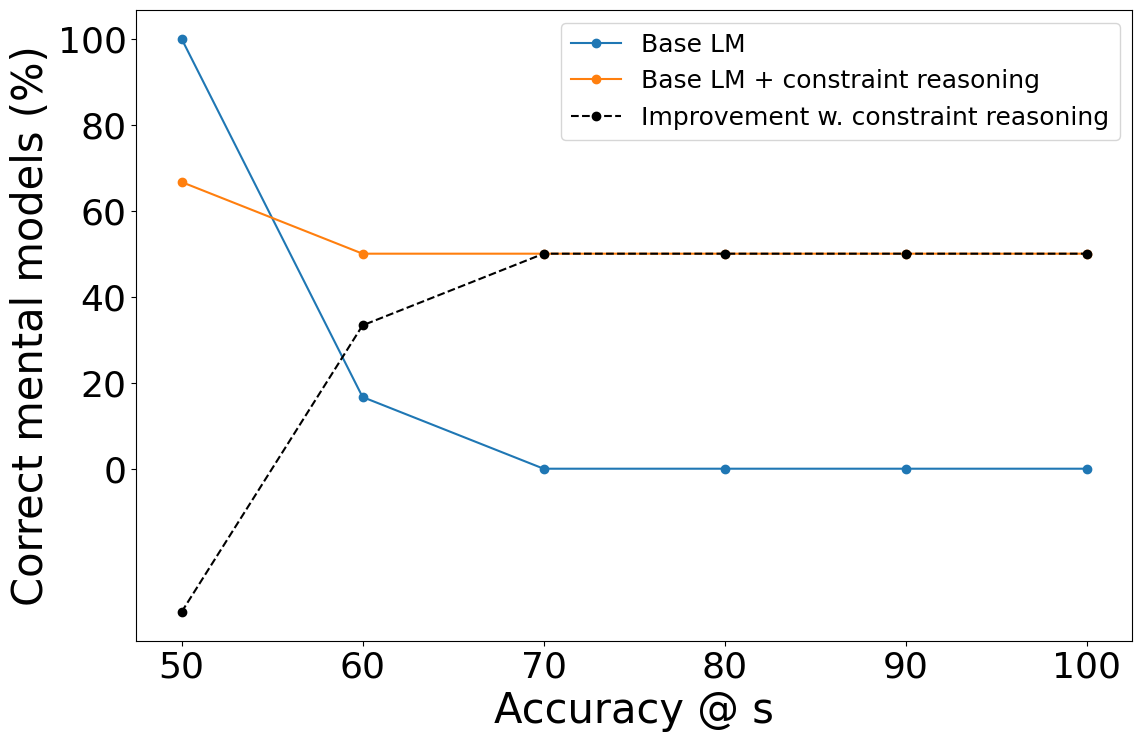

In [17]:
plt.rcParams['figure.figsize'] = 12, 8
SMALL_SIZE = 26
MEDIUM_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)

# naming the x and y axis
plt.xlabel('Accuracy @ s')
plt.ylabel('Correct mental models (%)')
# plot before and after (acc @ s)
for before_after in acc_at_s:
    # print(acc_at_s[before_after])
    acc_at_s_tuples = sorted(acc_at_s[before_after].items())
    x, y = zip(*acc_at_s_tuples) 
    # print(x,[y_cnt/mm_total * 100 for y_cnt in y])
    plt.plot(x, [y_cnt/mm_total * 100 for y_cnt in y], "o-", label=before_after)
    
diff_acc_at_s_y = []
diff_acc_at_s_x = []
for acc_s in acc_at_s['model_believe_true_props']:
    diff_acc_at_s_y.append((acc_at_s['maxsat_selected_props'][acc_s] - acc_at_s['model_believe_true_props'][acc_s])/mm_total * 100)
    diff_acc_at_s_x.append(acc_s)
plt.plot(diff_acc_at_s_x, diff_acc_at_s_y, "ko--", label="improvement")

plt.legend(['Base LM', 'Base LM + constraint reasoning', 'Improvement w. constraint reasoning'], fontsize=18)

#plt.axhline(y = 50, color = 'k', linestyle = 'dashed')
plt.yticks(range(0, 110, 20))
plt.tight_layout()
# plt.savefig(plots_dir + "/" + model_name + "_" + "acc_at_s.png")
plt.show()

In [20]:
print(rln2_correct_total_overall)

{'model_believe_true_props': {'surrounds': {'correct': 7, 'total': 14}, 'inside': {'correct': 1, 'total': 2}, 'surrounded by': {'correct': 7, 'total': 14}, 'contains': {'correct': 1, 'total': 2}, 'connects': {'correct': 7, 'total': 8}, 'above': {'correct': 9, 'total': 18}, 'below': {'correct': 9, 'total': 18}}, 'maxsat_selected_props': {'surrounds': {'correct': 6, 'total': 14}, 'inside': {'correct': 2, 'total': 2}, 'surrounded by': {'correct': 6, 'total': 14}, 'contains': {'correct': 2, 'total': 2}, 'connects': {'correct': 8, 'total': 8}, 'above': {'correct': 14, 'total': 18}, 'below': {'correct': 14, 'total': 18}}}


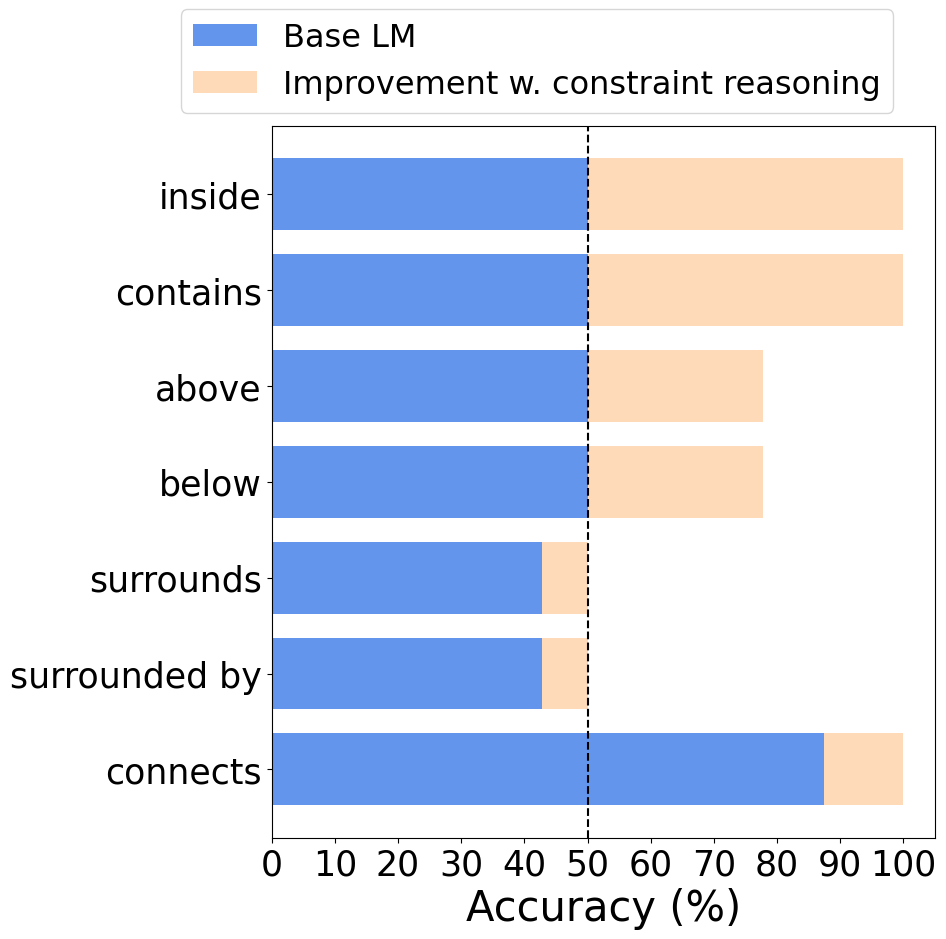

In [21]:
plt.rcParams['figure.figsize'] = 12, 10
SMALL_SIZE = 25
MEDIUM_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)

#“Base LM”, “Base LM + constraint reasoning”
category_names = ['Base LM', 'Improvement w. constraint reasoning']
category_colors = ['cornflowerblue', 'peachpuff']
results = {}

for relation in all_relations_lst:
    if relation in rln2_correct_total_overall['model_believe_true_props'] and relation in rln2_correct_total_overall['maxsat_selected_props']:  # added because not enough data yet
        accuracy_before = rln2_correct_total_overall['model_believe_true_props'][relation]["correct"]/rln2_correct_total_overall['model_believe_true_props'][relation]["total"]
        percent_correct_before = round(accuracy_before * 100, 2)
    
        accuracy_after = rln2_correct_total_overall['maxsat_selected_props'][relation]["correct"]/rln2_correct_total_overall['maxsat_selected_props'][relation]["total"]
        improvement = accuracy_after - accuracy_before
        percent_improvement = round(improvement * 100, 2)

        results[relation] = [percent_correct_before, percent_improvement]



def survey(results, category_names, category_colors):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)

    fig, ax = plt.subplots(figsize=(10, 10), dpi = 100)
    ax.invert_yaxis()

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.75,
                label=colname, color=color)
        xcenters = starts + widths / 2


#         text_color = 'white' 
#         for y, (x, c) in enumerate(zip(xcenters, widths)):
#             ax.text(x, y, str(int(c)), ha='center', va='center',
#                     color=text_color, fontsize='small')
    ax.legend(ncol=1, bbox_to_anchor=(0., 1.04, 0.8, .102),
             loc='center', fontsize = SMALL_SIZE - 2)

    ax.axvline(x=50, color='black', linestyle='--')
    ax.set_xticks(range(0,110,10))
    ax.set_xlabel('Accuracy (%)')

    return fig, ax


survey(results, category_names, category_colors)
plt.tight_layout()
# plt.savefig(plots_dir + "/" + model_name + "_" + "acc_by_relation.png")
plt.show()

In [22]:
results

{'inside': [50.0, 50.0],
 'contains': [50.0, 50.0],
 'above': [50.0, 27.78],
 'below': [50.0, 27.78],
 'surrounds': [50.0, -7.14],
 'surrounded by': [50.0, -7.14],
 'connects': [87.5, 12.5]}

In [23]:
et_100 = [et for et in sorted(list(et2_correct_total_overall['model_believe_true_props'].keys()))]

In [24]:
category_names = ['Model believe', 'Improvement w. MaxSAT']
category_colors = ['cornflowerblue', 'peachpuff']
results = {}

for et in et_100:
    accuracy_before = et2_correct_total_overall['model_believe_true_props'][et]["correct"]/et2_correct_total_overall['model_believe_true_props'][et]["total"]
    percent_correct_before = round(accuracy_before * 100, 2)
    
    accuracy_after = et2_correct_total_overall['maxsat_selected_props'][et]["correct"]/et2_correct_total_overall['maxsat_selected_props'][et]["total"]
    improvement = accuracy_after - accuracy_before
    percent_improvement = round(improvement * 100, 2)

    results[et.replace("-", " ")] = [percent_correct_before, percent_improvement]

In [25]:
# sort by improvment
#results_by_improvement = {k: v for k, v in sorted(results.items(), key=lambda item: item[1][1], reverse=True)}
results_by_improvement = {k: v for k, v in sorted(results.items(), key=lambda item: item[1][0], reverse=True)}
results_by_improvement_lists = {1 : {}, 2: {}, 3: {}, 4: {}, 5: {}}

for idx_et, et in enumerate(results_by_improvement):
    if results_by_improvement[et][1] < 0: 
        results_by_improvement_lists[idx_et//20 + 1][et] = [results_by_improvement[et][0] + results_by_improvement[et][1], 0, -results_by_improvement[et][1]]
    else:
        results_by_improvement_lists[idx_et//20 + 1][et] = results_by_improvement[et] + [0]

FileNotFoundError: [Errno 2] No such file or directory: 'plots/Macaw_acc_by_et_best_initial20.png'

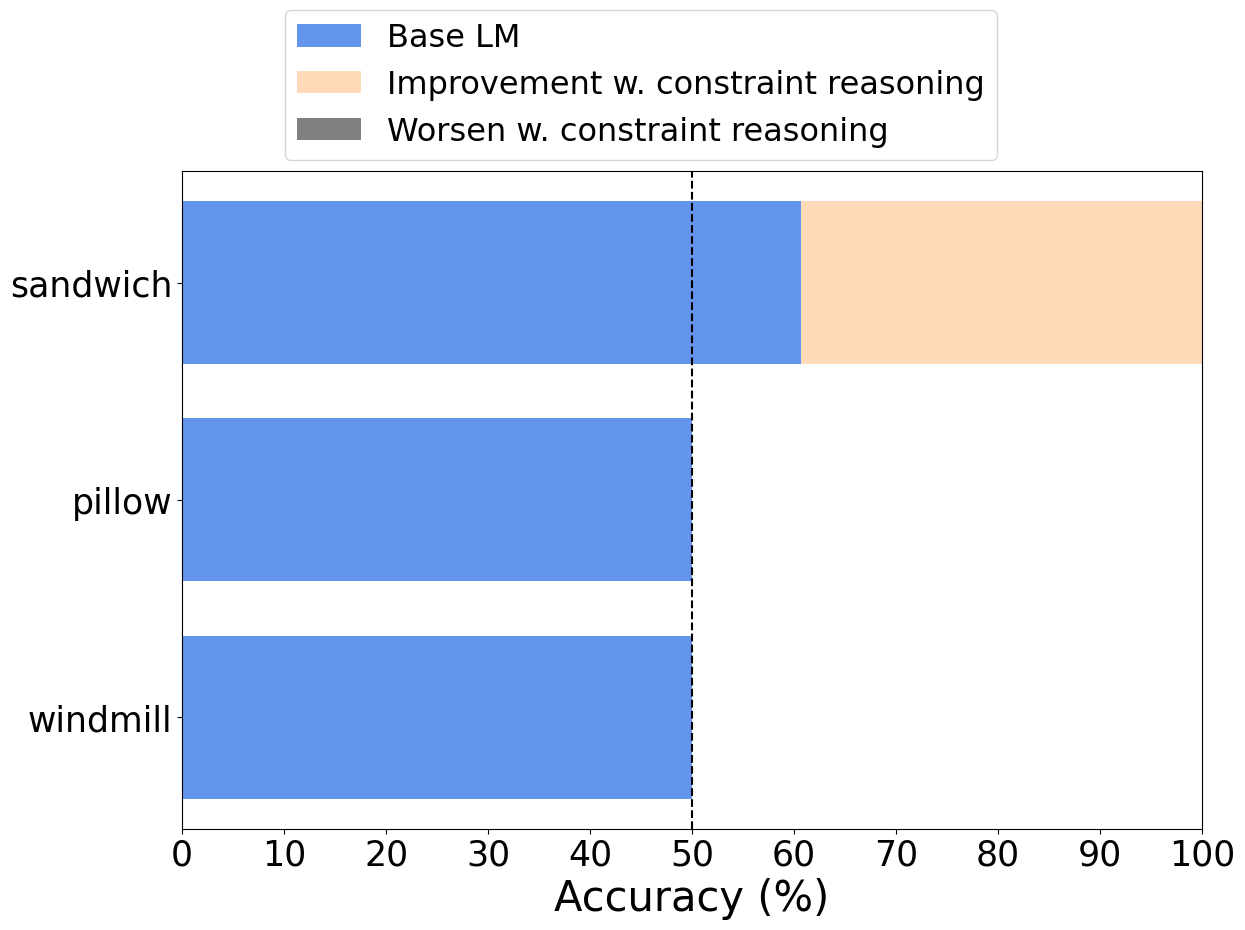

In [27]:
def survey(results, category_names, category_colors):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)

    fig, ax = plt.subplots(figsize=(13, 10), dpi=100)
    ax.invert_yaxis()

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.75,
                label=colname, color=color)
        xcenters = starts + widths / 2


#         text_color = 'white' 
#         for y, (x, c) in enumerate(zip(xcenters, widths)):
#             ax.text(x, y, str(int(c)), ha='center', va='center',
#                     color=text_color, fontsize='small')
    ax.legend(ncol=1, bbox_to_anchor=(0., 1.08, 0.9, .102),
              loc='center', fontsize = SMALL_SIZE - 2)

    ax.axvline(x=50, color='black', linestyle='--')
    ax.set_xticks(range(0,110,10))
    ax.set_xlabel('Accuracy (%)')

    return fig, ax


# category_names = ['Base LM', 'Improvement w. constraint reasoning']
# category_colors = ['cornflowerblue', 'peachpuff']
category_names = ['Base LM', 'Improvement w. constraint reasoning', "Worsen w. constraint reasoning"]
category_colors = ['cornflowerblue', 'peachpuff', 'gray']
survey(results_by_improvement_lists[1], category_names, category_colors)
plt.tight_layout()
plt.savefig(plots_dir + "/"+ "Macaw" + "_" + "acc_by_et_best_initial20.png")
plt.show()

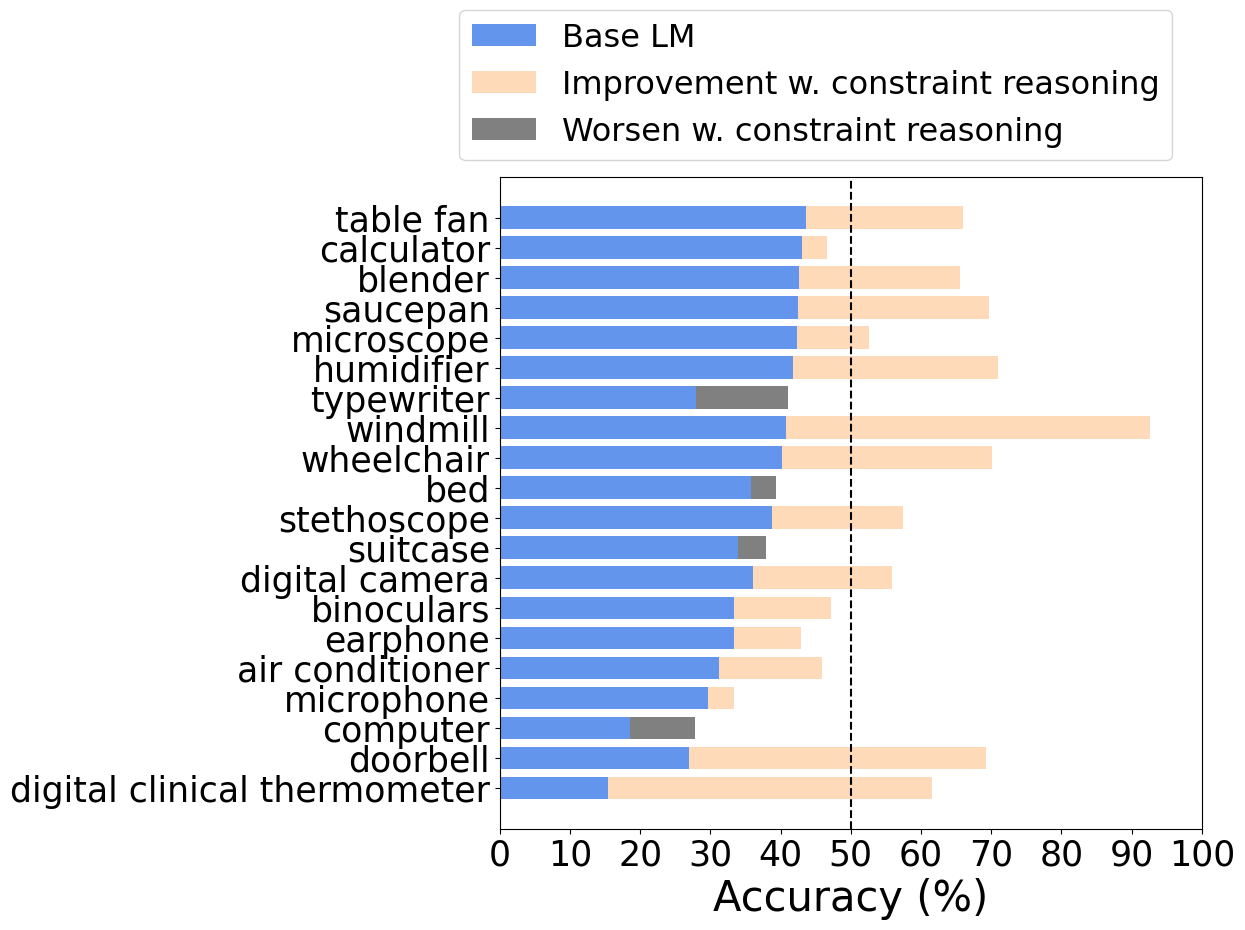

In [22]:
def survey(results, category_names, category_colors):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)

    fig, ax = plt.subplots(figsize=(13, 10), dpi=100)
    ax.invert_yaxis()

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.75,
                label=colname, color=color)
        xcenters = starts + widths / 2


#         text_color = 'white' 
#         for y, (x, c) in enumerate(zip(xcenters, widths)):
#             ax.text(x, y, str(int(c)), ha='center', va='center',
#                     color=text_color, fontsize='small')
    ax.legend(ncol=1, bbox_to_anchor=(0., 1.09, 0.90, .102),
              loc='center', fontsize = SMALL_SIZE - 2)

    ax.axvline(x=50, color='black', linestyle='--')
    ax.set_xticks(range(0,110,10))
    ax.set_xlabel('Accuracy (%)')

    return fig, ax
category_names = ['Base LM', 'Improvement w. constraint reasoning', "Worsen w. constraint reasoning"]
category_colors = ['cornflowerblue', 'peachpuff', 'gray']
survey(results_by_improvement_lists[5], category_names, category_colors)
plt.tight_layout()
plt.savefig(plots_dir + "/" + model_name + "_" + "acc_by_et_worse_initial20.png")
plt.show()

In [23]:
merged = {**results_by_improvement_lists[2], **results_by_improvement_lists[3], **results_by_improvement_lists[4]}

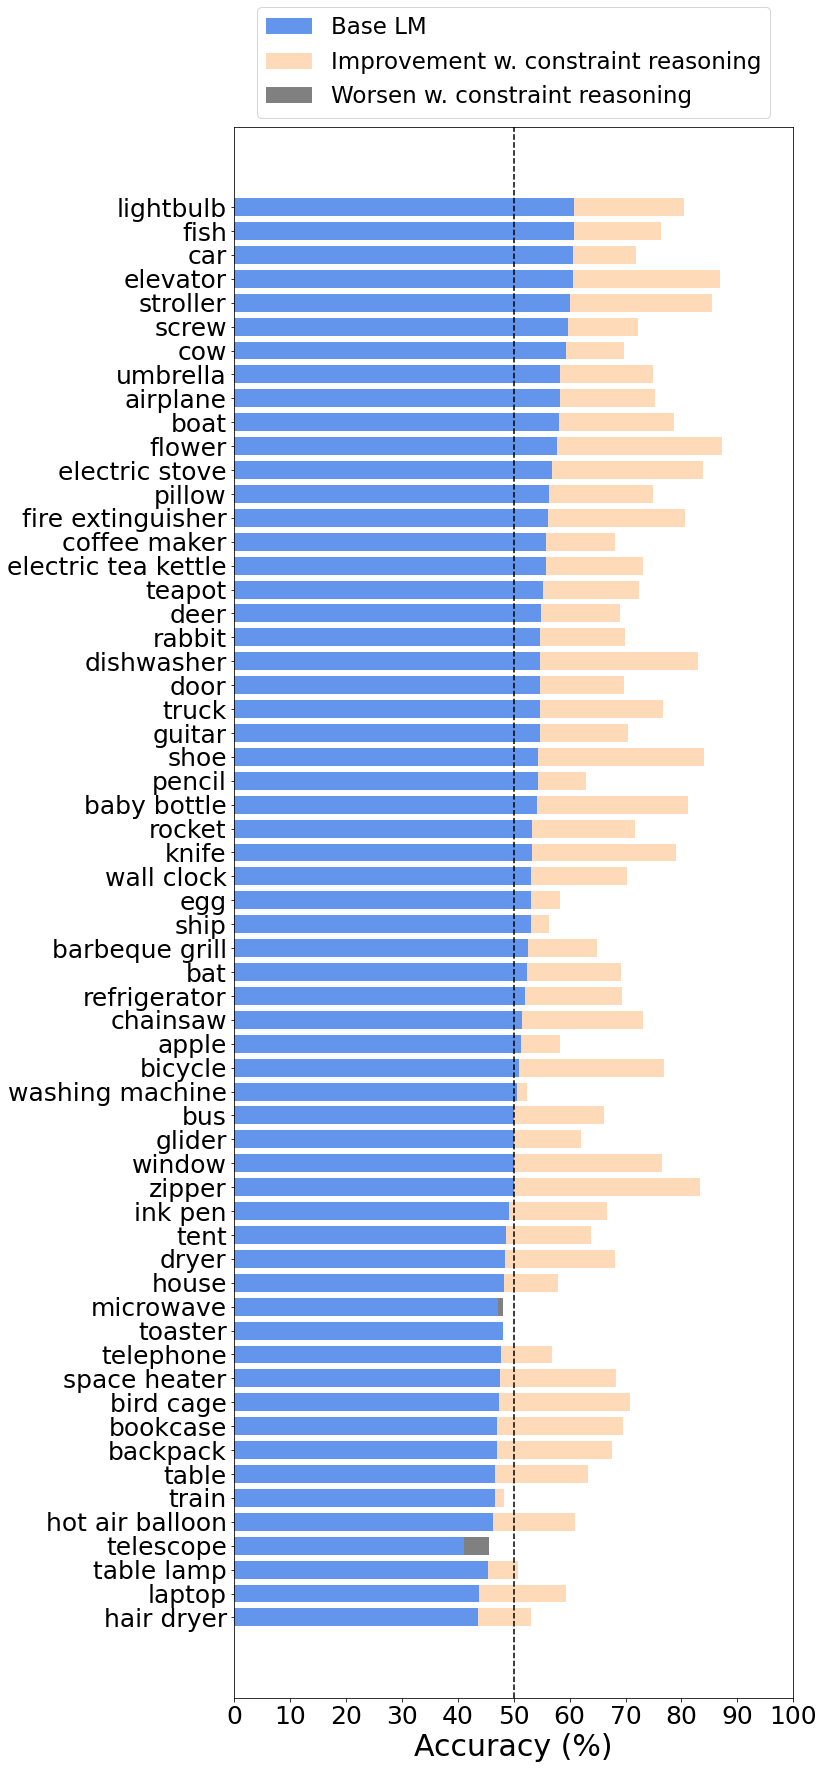

In [24]:
plt.rcParams['figure.figsize'] = 25, 15
def survey(results, category_names, category_colors):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)

    fig, ax = plt.subplots(figsize=(12, 25))
    ax.invert_yaxis()

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.75,
                label=colname, color=color)
        xcenters = starts + widths / 2


#         text_color = 'white' 
#         for y, (x, c) in enumerate(zip(xcenters, widths[:2])):
#             ax.text(x, y, str(int(c)), ha='center', va='center',
#                     color=text_color, fontsize='small')
    ax.legend(ncol=1, bbox_to_anchor=(0., 0.99, 1.0, .102),
              loc='center', fontsize = SMALL_SIZE - 2)

    ax.axvline(x=50, color='black', linestyle='--')
    ax.set_xticks(range(0,110,10))
    ax.set_xlabel('Accuracy (%)')

    return fig, ax

# category_names = ['Base LM', 'Improvement w. constraint reasoning']
# category_colors = ['cornflowerblue', 'peachpuff']
category_names = ['Base LM', 'Improvement w. constraint reasoning', "Worsen w. constraint reasoning"]
category_colors = ['cornflowerblue', 'peachpuff', 'gray']
survey(merged, category_names, category_colors)
plt.tight_layout()
plt.savefig(plots_dir + "/" + model_name + "_" + "acc_by_et_accuracy-middle21-80.png")
plt.show()

In [25]:
merged

{'lightbulb': [60.87, 19.57, 0],
 'fish': [60.82, 15.46, 0],
 'car': [60.68, 11.17, 0],
 'elevator': [60.53, 26.32, 0],
 'stroller': [60.11, 25.28, 0],
 'screw': [59.72, 12.5, 0],
 'cow': [59.38, 10.42, 0],
 'umbrella': [58.33, 16.67, 0],
 'airplane': [58.26, 16.97, 0],
 'boat': [58.04, 20.54, 0],
 'flower': [57.69, 29.49, 0],
 'electric stove': [56.88, 26.88, 0],
 'pillow': [56.25, 18.75, 0],
 'fire extinguisher': [56.14, 24.56, 0],
 'coffee maker': [55.85, 12.23, 0],
 'electric tea kettle': [55.77, 17.31, 0],
 'teapot': [55.17, 17.24, 0],
 'deer': [54.85, 14.08, 0],
 'rabbit': [54.76, 15.08, 0],
 'dishwasher': [54.72, 28.3, 0],
 'door': [54.72, 15.09, 0],
 'truck': [54.65, 22.09, 0],
 'guitar': [54.63, 15.74, 0],
 'shoe': [54.35, 29.71, 0],
 'pencil': [54.29, 8.57, 0],
 'baby bottle': [54.17, 27.08, 0],
 'rocket': [53.36, 18.28, 0],
 'knife': [53.29, 25.66, 0],
 'wall clock': [53.19, 17.02, 0],
 'egg': [53.12, 5.21, 0],
 'ship': [53.12, 3.12, 0],
 'barbeque grill': [52.63, 12.28, 0],